  - Training a small image classificaition model (MobileNetV2) on a small dataset (FashionMnist).
  -My goal is to both practice my basic deep learning skills that I've learned from a tutorial and to prepare a work sample.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
  import torchmetrics
except:
  !pip install -q torchmetrics
  import torchmetrics


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
from typing import Dict, List
from tqdm.auto import tqdm
import math


def train_model(model, dataloader, optimizer, loss_fn, device):
  """
  Trains a model and returns loss and accuracy.

  Args:
      model: the model to train
      dataloader: the dataloader used for training.
      optimizer: optimizer instance.
      loss_fn: loss function.
      device: target device ("cuda" or "cpu").

    Returns:
      a tuple of 2 float numbers. First one being the training loss and
      the second one being the accuracy.
  """
  loss_sum = 0
  accuracy_sum = 0
  model.train()
  for X, y in tqdm(dataloader, "Training..."):
    y = y.to(device)
    preds = model(X.to(device))
    preds_y = torch.softmax(preds, 1).argmax(1)

    loss = loss_fn(preds, y)
    loss_sum += loss.item()

    # computing accuracy using the fact True is converted to 1 and False is converted to 0
    accuracy = (preds_y == y).sum().item() / len(y)
    accuracy_sum += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_total = loss_sum /len(dataloader)
  accuracy_total = accuracy_sum / len(dataloader)

  return loss_total, accuracy_total


def test_model(model, dataloader, loss_fn, device):
  """
  Tests a model and returns test loss and accuracy.

  Args:
      model: the model we are testing
      dataloader: the dataloader used for testing.
      loss_fn: loss function.
      device: target device ("cuda" or "cpu").

    Returns:
      a tuple of 2 float numbers. First one being the test loss and
      the second one being the accuracy.
  """
  loss_sum = 0
  accuracy_sum = 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, "Testing..."):
      y = y.to(device)
      preds = model(X.to(device))
      preds_y = torch.softmax(preds, 1).argmax(1)

      loss = loss_fn(preds, y)
      loss_sum += loss.item()

      # computing accuracy using the fact True is converted to 1 and False is converted to 0
      accuracy = (preds_y == y).sum().item() / len(y)
      accuracy_sum += accuracy

  loss_total = loss_sum /len(dataloader)
  accuracy_total = accuracy_sum / len(dataloader)

  return loss_total, accuracy_total

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device
          ) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Args:
      model: the model instance we are training
      train_dataloader: dataloader used for training
      test_dataloader: dataloader used for testing
      optimizer: optimizer instance.
      loss_fn: loss function.
      epochs: number of training epochs.
      device: target device("cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
    """
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_model(model,
                                            train_dataloader,
                                            optimizer,
                                            loss_fn,
                                            device)
        test_loss, test_acc = test_model(model,
                                        test_dataloader,
                                        loss_fn,
                                        device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

- I'm using horizontal flip and invert transformations in order to augment training data. Using TrivialAugmentWide resulted in high loss during training while testing had much lower loss (almost half). This caused results to be unpredictable.
- Also, for both train and transforms, I need to increase image channels from 1 to 3, since MobileNetV2 expects 3-channel images.

In [5]:
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)), # to conver single channel fashionmnist pictures into 3-channel pictures
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)), # to conver single channel fashionmnist pictures into 3-channel pictures
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# for testing with custom images
simple_transform_no_chan = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
from torchvision import datasets

set_seeds()
fashionmnist_train_dataset = datasets.FashionMNIST("fasionmnist", train=True, download=True, transform=train_transform)
fashionmnist_test_dataset = datasets.FashionMNIST("fasionmnist", train=False, download=True, transform=simple_transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.7MB/s]


In [7]:
from torch.utils.data import DataLoader

set_seeds()
fashionminst_train_dataloder = DataLoader(fashionmnist_train_dataset, 32, True)
fashionminst_test_dataloader = DataLoader(fashionmnist_test_dataset, 32, False)
class_names = fashionmnist_train_dataset.classes

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Initialize model and change output channels to 10 (number of FashionMnist classes).

In [8]:
from torchvision import models

set_seeds()
model = models.mobilenet_v2().to(device)

model.classifier[1] = nn.Linear(1280, 10).to(device)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [10]:
set_seeds()
# 10 epochs should be enough
train(model, fashionminst_train_dataloder, fashionminst_test_dataloader, optimizer, loss_fn, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8866 | train_acc: 0.6924 | test_loss: 0.6632 | test_acc: 0.7481


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5535 | train_acc: 0.8107 | test_loss: 0.4370 | test_acc: 0.8322


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4621 | train_acc: 0.8418 | test_loss: 0.3808 | test_acc: 0.8680


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4102 | train_acc: 0.8602 | test_loss: 0.3631 | test_acc: 0.8695


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3754 | train_acc: 0.8705 | test_loss: 0.3414 | test_acc: 0.8850


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.3550 | train_acc: 0.8764 | test_loss: 0.3172 | test_acc: 0.8881


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.3274 | train_acc: 0.8857 | test_loss: 0.3005 | test_acc: 0.8935


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.3112 | train_acc: 0.8920 | test_loss: 0.3117 | test_acc: 0.8865


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.2938 | train_acc: 0.8964 | test_loss: 0.2843 | test_acc: 0.9007


Training...:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing...:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.2843 | train_acc: 0.8995 | test_loss: 0.2720 | test_acc: 0.9026


{'train_loss': [0.8865849831581115,
  0.553542463517189,
  0.46206713879505795,
  0.4101810818711917,
  0.3754043836355209,
  0.35499035604596135,
  0.3274177305459976,
  0.31120678416689235,
  0.2938052185455958,
  0.28431405368645984],
 'train_acc': [0.6923666666666667,
  0.8107333333333333,
  0.8417833333333333,
  0.8601833333333333,
  0.8704833333333334,
  0.8764166666666666,
  0.8857333333333334,
  0.89195,
  0.89645,
  0.8995166666666666],
 'test_loss': [0.663165387635033,
  0.4370307076377229,
  0.38078542010852706,
  0.3630588608451735,
  0.34143408185567337,
  0.3172002559700332,
  0.30050389762646473,
  0.3116538984754596,
  0.28434696454352465,
  0.27195723555958307],
 'test_acc': [0.74810303514377,
  0.8321685303514377,
  0.8680111821086262,
  0.869508785942492,
  0.8849840255591054,
  0.8880790734824281,
  0.893470447284345,
  0.8864816293929713,
  0.900658945686901,
  0.902555910543131]}

Some functions to test how is the trained model is performing.

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def classify_image(model, image_path, device):
  img = Image.open(image_path).convert('RGB')
  model.eval()
  with torch.inference_mode():
    img_trans = simple_transform_no_chan(img)
    pred = model(img_trans.unsqueeze(0).to(device))
    softmax_pred = torch.softmax(pred, 1)
    for i, elem in enumerate(softmax_pred[0]):
      print(f"{elem:.2f}, {class_names[i]}")
    print(softmax_pred.argmax().item())
    plt.title(class_names[softmax_pred.argmax().item()])
    plt.imshow(img_trans.permute(1, 2, 0))

def rand_classify_image(model, test_dataset, device):
  indx = random.randrange(0, len(test_dataset))
  X, y = test_dataset[indx]
  X = X.to(device)
  model.eval()
  with torch.inference_mode():
    # img_trans = simple_transform(X)
    pred = model(X.unsqueeze(0))
    softmax_pred = torch.softmax(pred, 1)
    for i, elem in enumerate(softmax_pred[0]):
      print(f"{elem:.2f}, {class_names[i]}")
    print(softmax_pred.argmax().item())
    plt.title(class_names[softmax_pred.argmax().item()] + ", should be: " + class_names[y])
    plt.imshow(X.to("cpu").permute(1, 2, 0))


0.00, T-shirt/top
0.00, Trouser
0.00, Pullover
0.00, Dress
0.03, Coat
0.00, Sandal
0.97, Shirt
0.00, Sneaker
0.00, Bag
0.00, Ankle boot
6


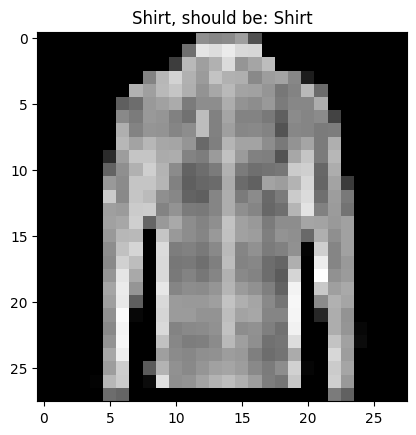

In [12]:
rand_classify_image(model, fashionmnist_test_dataset, device)

Load and image from an url for testing.

In [13]:
import requests

req = requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQY1YdpzlzApKDH-l6ynGxFJU5zSRkD8vHWFQ&s")

with open("tstfile.jpg", "wb") as f:
  f.write(req.content)


0.11, T-shirt/top
0.02, Trouser
0.01, Pullover
0.79, Dress
0.01, Coat
0.00, Sandal
0.05, Shirt
0.00, Sneaker
0.01, Bag
0.00, Ankle boot
3


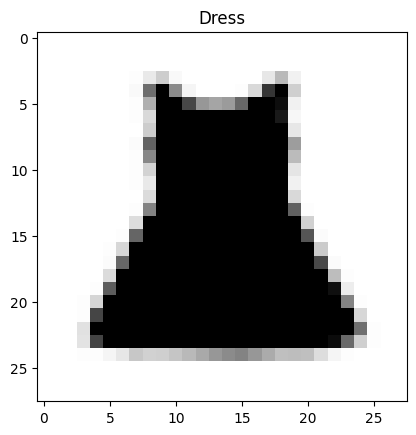

In [14]:
classify_image(model, "tstfile.jpg", device)

Drawing a confusion matrix.

In [17]:
import torchmetrics, mlxtend

from tqdm.auto import tqdm
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(fashionminst_test_dataloader):
    logits = model(X.to(device))
    preds = torch.softmax(logits.squeeze(), 0).argmax(1)
    y_preds.append(preds.cpu())

y_preds_tens = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

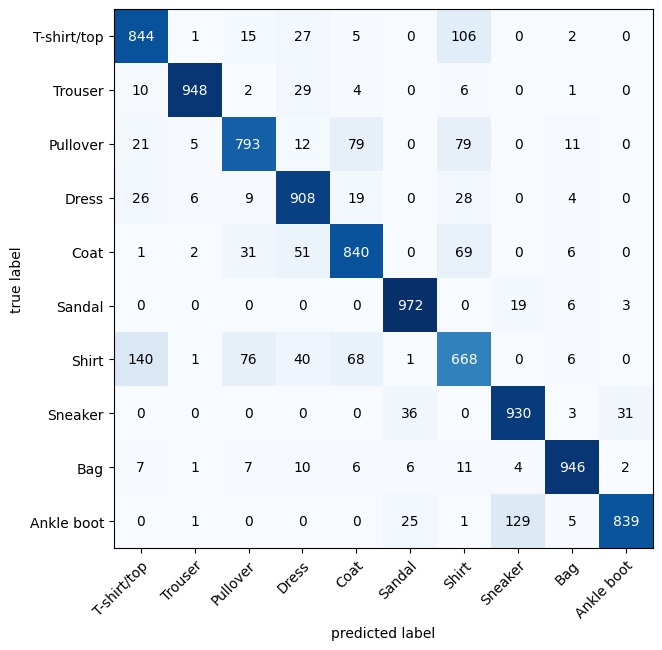

In [18]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
targets_tensor = torch.Tensor(fashionminst_test_dataloader.dataset.targets)
conf_tensor = conf(preds=y_preds_tens, target=targets_tensor)

a, f = plot_confusion_matrix(conf_mat=conf_tensor.numpy(), class_names=class_names, figsize=(10, 7))

For saving and loading purposes.

In [20]:
model_name = "mobilenetv2_fashionmninst_10_epochs.pth"

In [19]:
torch.save(model.state_dict(), model_name)

In [ ]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>